In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
file_path = '/Users/mmurali1/Documents/Imperial/MIMICIV_analysis/labevents_bloodgas.csv'

# Load the CSV into a DataFrame
bloodgas = pd.read_csv(file_path)

# Display the first few rows to confirm it loaded correctly
print(bloodgas.head())

   subject_id            charttime  itemid  valuenum
0    10002428  2156-04-12 10:29:00   50813       2.2
1    10002428  2156-04-12 12:24:00   50813       2.0
2    10002428  2156-04-12 19:49:00   50813       1.6
3    10002428  2156-04-13 01:58:00   50813       1.5
4    10002428  2156-04-13 06:23:00   50813       1.8


In [40]:
bloodgas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 911431 entries, 0 to 911430
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   subject_id  911431 non-null  int64  
 1   charttime   911431 non-null  object 
 2   itemid      911431 non-null  int64  
 3   valuenum    910832 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 27.8+ MB


In [41]:
# Convert charttime to an datetime
bloodgas['charttime'] = bloodgas['charttime'].astype('datetime64[ns]')
bloodgas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 911431 entries, 0 to 911430
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   subject_id  911431 non-null  int64         
 1   charttime   911431 non-null  datetime64[ns]
 2   itemid      911431 non-null  int64         
 3   valuenum    910832 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 27.8 MB


In [42]:
# Count the number of unique subject_ids / patients in this dataframe
print(f'Number of patients: {bloodgas["subject_id"].nunique()}')

Number of patients: 5818


In [43]:
# Load the d_items CSV
d_labitems_path = '/Users/mmurali1/Documents/Imperial/MIMICIV_analysis/mimic-iv-3.1/hosp/d_labitems_2.csv'
d_labitems = pd.read_csv(d_labitems_path)

# Merge the label column into the ventilation dataframe using itemid
bloodgas = bloodgas.merge(
    d_labitems[['itemid', 'label']],  # Only keep necessary columns
    on='itemid',
    how='left'  # Keep all rows from ventilation
)

In [44]:
bloodgas.head()

,subject_id,charttime,itemid,valuenum,label
0,10002428,2156-04-12 10:29:00,50813,2.2,Lactate
1,10002428,2156-04-12 12:24:00,50813,2.0,Lactate
2,10002428,2156-04-12 19:49:00,50813,1.6,Lactate
3,10002428,2156-04-13 01:58:00,50813,1.5,Lactate
4,10002428,2156-04-13 06:23:00,50813,1.8,Lactate


In [45]:
bloodgas.shape

(911431, 5)

In [46]:
# Group by itemid and count nulls in 'valuenum' column only
null_counts = bloodgas.groupby('itemid')['valuenum'].apply(lambda x: x.isnull().sum()).reset_index(name='null_valuenum')

null_counts

,itemid,null_valuenum
0,50802,85
1,50803,4
2,50805,5
3,50806,7
4,50809,161
5,50810,2
6,50811,0
7,50813,38
8,50814,8
9,50818,80


In [47]:
# Load the d_items CSV
d_labitems_path = '/Users/mmurali1/Documents/Imperial/MIMICIV_analysis/mimic-iv-3.1/hosp/d_labitems_2.csv'
d_labitems = pd.read_csv(d_labitems_path)

# Merge the label column into the ventilation dataframe using itemid
null_counts = null_counts.merge(
    d_labitems[['itemid', 'label']],  # Only keep necessary columns
    on='itemid',
    how='left'  # Keep all rows from ventilation
)

null_counts

,itemid,null_valuenum,label
0,50802,85,Base Excess
1,50803,4,"Calculated Bicarbonate, Whole Blood"
2,50805,5,Carboxyhemoglobin
3,50806,7,"Chloride, Whole Blood"
4,50809,161,Glucose
5,50810,2,"Hematocrit, Calculated"
6,50811,0,Hemoglobin
7,50813,38,Lactate
8,50814,8,Methemoglobin
9,50818,80,pCO2


In [48]:
# Average, minimum and maximum time of each individual in dataframe

# Group by subject_id and calculate duration per subject
duration_per_subject = bloodgas.groupby('subject_id')['charttime'].agg(['min', 'max'])
duration_per_subject['duration_hours'] = (
    (duration_per_subject['max'] - duration_per_subject['min']).dt.total_seconds() / 3600
)

# Summary statistics
average_duration = duration_per_subject['duration_hours'].mean()
min_duration = duration_per_subject['duration_hours'].min()
max_duration = duration_per_subject['duration_hours'].max()

print(f"🟢 Average time span per subject: {average_duration:.2f} hours")
print(f"🔵 Shortest time span: {min_duration:.2f} hours")
print(f"🔴 Longest time span: {max_duration:.2f} hours")

🟢 Average time span per subject: 14215.85 hours
🔵 Shortest time span: 0.00 hours
🔴 Longest time span: 137574.30 hours


In [49]:
# Group by itemid
grouped = bloodgas.groupby('itemid')

# Define the frequency function
def avg_obs_per_20_hours(group):
    n_obs = len(group)
    time_span_hours = (group['charttime'].max() - group['charttime'].min()).total_seconds() / 3600
    return (n_obs / time_span_hours * 20) if time_span_hours > 0 else float('nan')

# Apply the function to the cleaned dataframe
avg_freq_df = grouped.apply(avg_obs_per_20_hours).reset_index(name='avg_obs_per_20_hours')

/var/folders/ks/xzsx5z1n0zv653847sbsxy7r0000gp/T/ipykernel_26445/1991635491.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  avg_freq_df = grouped.apply(avg_obs_per_20_hours).reset_index(name='avg_obs_per_20_hours')


In [50]:
# Load the d_items CSV
d_labitems_path = '/Users/mmurali1/Documents/Imperial/MIMICIV_analysis/mimic-iv-3.1/hosp/d_labitems_2.csv'
d_labitems = pd.read_csv(d_labitems_path)

# Merge the label column into the ventilation dataframe using itemid
avg_freq_df = avg_freq_df.merge(
    d_labitems[['itemid', 'label']],  # Only keep necessary columns
    on='itemid',
    how='left'  # Keep all rows from ventilation
)

avg_freq_df

,itemid,avg_obs_per_20_hours,label
0,50802,3.456449,Base Excess
1,50803,0.060795,"Calculated Bicarbonate, Whole Blood"
2,50805,0.017410,Carboxyhemoglobin
3,50806,0.308331,"Chloride, Whole Blood"
4,50809,1.032893,Glucose
5,50810,0.416782,"Hematocrit, Calculated"
6,50811,0.416782,Hemoglobin
7,50813,2.230566,Lactate
8,50814,0.015773,Methemoglobin
9,50818,3.455900,pCO2


In [51]:
# Dropping features that are measured < 0.3 per 20-hour period, apart from bicarbonate

# drop specific itemids
itemids_to_drop = [50805, 50814]
bloodgas2 = bloodgas[~bloodgas['itemid'].isin(itemids_to_drop)].copy()

In [52]:
bloodgas2.shape

(909971, 5)

In [53]:
# Check for outliers in the dataframe

summary_stats = bloodgas2.groupby('itemid')['valuenum'].agg(
    min_value='min',
    max_value='max',
    median_value='median'
).reset_index()

# Load the d_items CSV
d_labitems_path = '/Users/mmurali1/Documents/Imperial/MIMICIV_analysis/mimic-iv-3.1/hosp/d_labitems_2.csv'
d_labitems = pd.read_csv(d_labitems_path)

# Merge the label column into the ventilation dataframe using itemid
summary_stats = summary_stats.merge(
    d_labitems[['itemid', 'label']],  # Only keep necessary columns
    on='itemid',
    how='left' 
)

summary_stats

,itemid,min_value,max_value,median_value,label
0,50802,-413.00,188.00,0.00,Base Excess
1,50803,2.00,109.00,23.00,"Calculated Bicarbonate, Whole Blood"
2,50806,64.00,149.00,104.00,"Chloride, Whole Blood"
3,50809,0.12,793.00,126.00,Glucose
4,50810,0.00,288.00,29.00,"Hematocrit, Calculated"
5,50811,0.00,96.00,9.70,Hemoglobin
6,50813,0.00,29.00,1.70,Lactate
7,50818,7.00,210.00,41.00,pCO2
8,50820,4.57,7.95,7.39,pH
9,50821,-32.00,792.00,101.00,pO2


In [54]:
# Convert to UK units
# Glucose measured in mmol/L in the UK, and mg/dL in the US. Conversion is by dividing US value by 18
# pO2 and pCO2 measured in kPa in the UK, and mmHg in the US. Conversion is by multiplying US value by 0.1333

bloodgas3 = bloodgas2.copy()

# Divide valuenum by 18 where itemid == 50809
bloodgas3.loc[bloodgas3['itemid'] == 50809, 'valuenum'] /= 18

# Multiply valuenum by 0.1333 where itemid is 50818 or 50821
bloodgas3.loc[bloodgas3['itemid'].isin([50818, 50821]), 'valuenum'] *= 0.1333

bloodgas3.shape

(909971, 5)

In [55]:
# Check for outliers in the dataframe

summary_stats = bloodgas3.groupby('itemid')['valuenum'].agg(
    min_value='min',
    max_value='max',
    median_value='median'
).reset_index()

# Load the d_items CSV
d_labitems_path = '/Users/mmurali1/Documents/Imperial/MIMICIV_analysis/mimic-iv-3.1/hosp/d_labitems_2.csv'
d_labitems = pd.read_csv(d_labitems_path)

# Merge the label column into the ventilation dataframe using itemid
summary_stats = summary_stats.merge(
    d_labitems[['itemid', 'label']],  # Only keep necessary columns
    on='itemid',
    how='left' 
)

summary_stats

,itemid,min_value,max_value,median_value,label
0,50802,-413.000000,188.000000,0.0000,Base Excess
1,50803,2.000000,109.000000,23.0000,"Calculated Bicarbonate, Whole Blood"
2,50806,64.000000,149.000000,104.0000,"Chloride, Whole Blood"
3,50809,0.006667,44.055556,7.0000,Glucose
4,50810,0.000000,288.000000,29.0000,"Hematocrit, Calculated"
5,50811,0.000000,96.000000,9.7000,Hemoglobin
6,50813,0.000000,29.000000,1.7000,Lactate
7,50818,0.933100,27.993000,5.4653,pCO2
8,50820,4.570000,7.950000,7.3900,pH
9,50821,-4.265600,105.573600,13.4633,pO2


In [56]:
# Define valid ranges for specific itemids
valid_ranges = {
    50802: (-25, 25),
    50803: (0, 50),
    50806: (60, 150),
    50809: (0, 50),
    50810: (0, 100),
    50811: (2, 20),
    50813: (0, 30),
    50818: (1, 20),
    50820: (6.50, 7.95),
    50821: (1, 70),
    50822: (0.5, 10),
    50824: (100, 170)
}

to_filter = bloodgas3[bloodgas3['itemid'].isin(valid_ranges.keys())].copy()

# Apply physiological range filtering to the filtered subset
def in_valid_range(row):
    low, high = valid_ranges[row['itemid']]
    return low <= row['valuenum'] <= high

bloodgas3 = to_filter[to_filter.apply(in_valid_range, axis=1)]

In [57]:
bloodgas3.shape

(908881, 5)

In [58]:
bloodgas3.head()

,subject_id,charttime,itemid,valuenum,label
0,10002428,2156-04-12 10:29:00,50813,2.2,Lactate
1,10002428,2156-04-12 12:24:00,50813,2.0,Lactate
2,10002428,2156-04-12 19:49:00,50813,1.6,Lactate
3,10002428,2156-04-13 01:58:00,50813,1.5,Lactate
4,10002428,2156-04-13 06:23:00,50813,1.8,Lactate


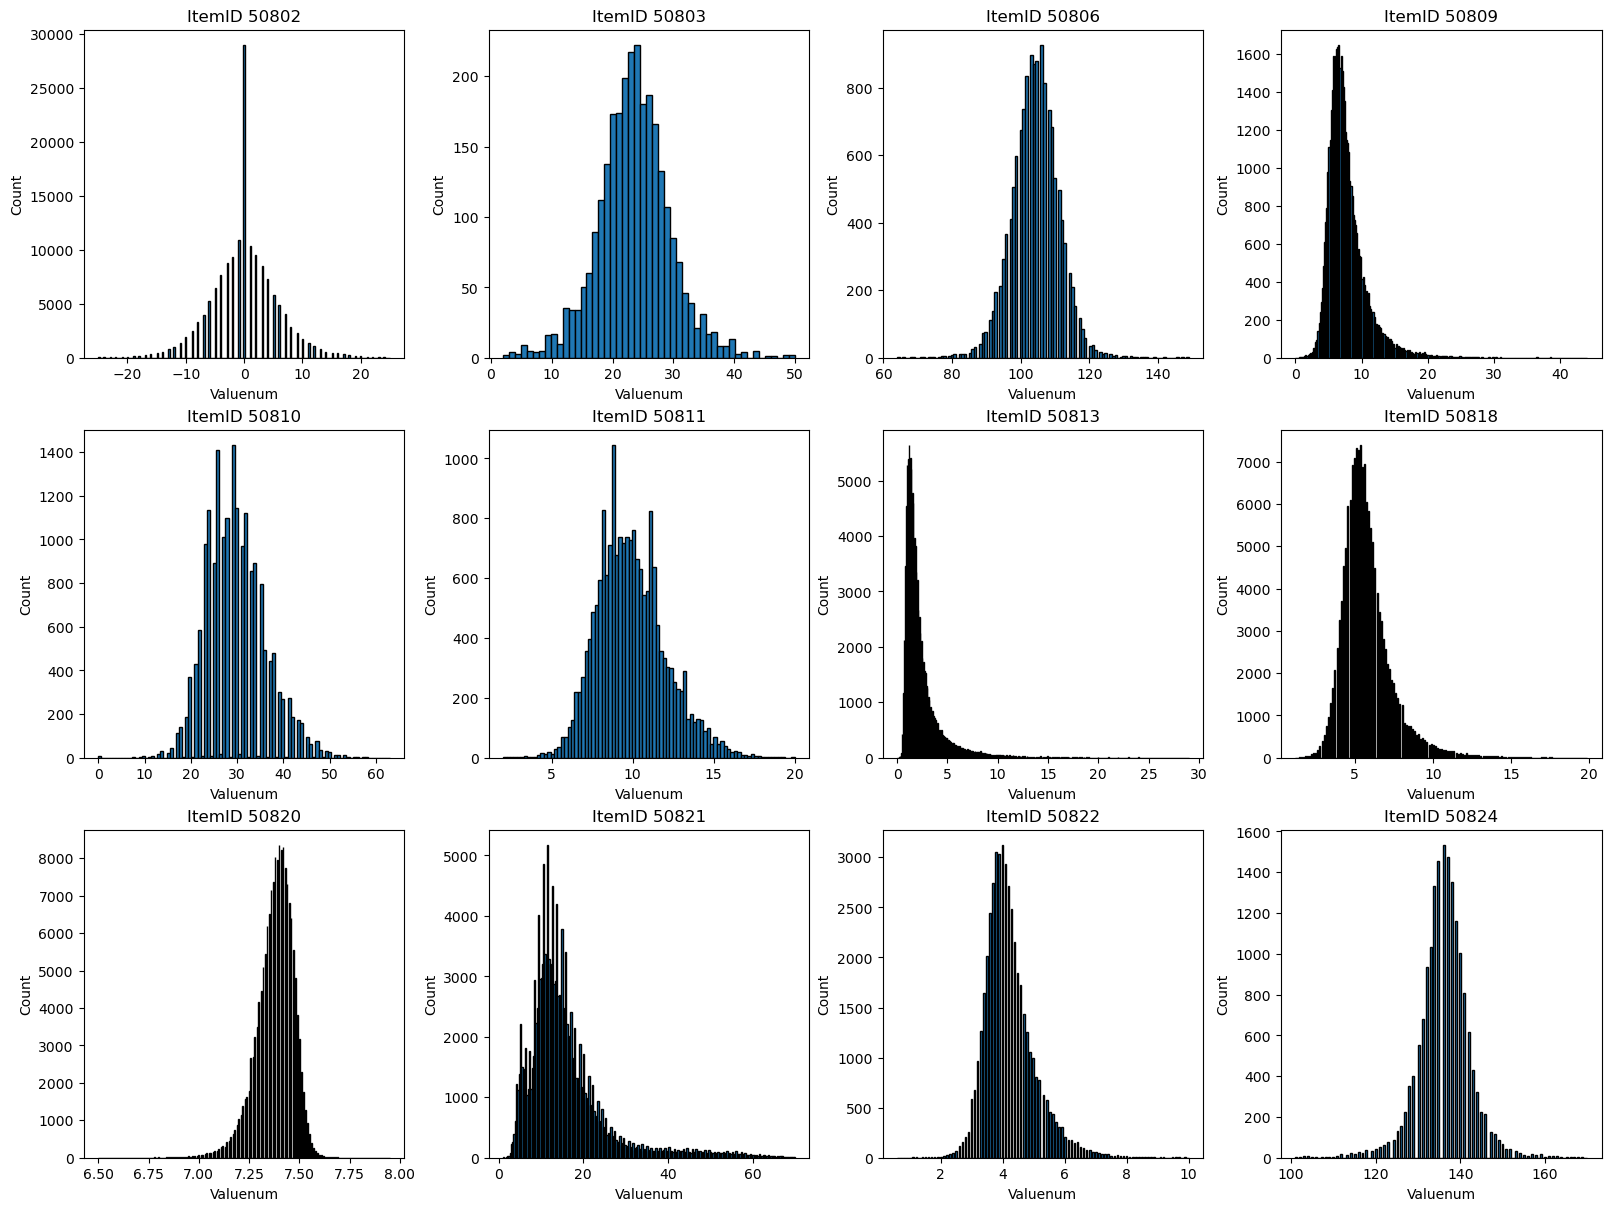

In [59]:
# Get unique itemids from bloodgas3
itemids = bloodgas3['itemid'].unique()

# Filter NaNs in valuenum
filtered = bloodgas3[bloodgas3['valuenum'].notna() & bloodgas3['itemid'].isin(itemids)]

# Group by itemid
grouped = filtered.groupby('itemid')['valuenum']

# Keep only non-empty groups
data_dict = {itemid: group for itemid, group in grouped if not group.empty}

# Plot configuration
n = len(data_dict)
cols = 4
rows = (n + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 4 * rows), constrained_layout=True)
axes = axes.flatten()

# Plot histograms
for ax, (itemid, data) in zip(axes, data_dict.items()):
    ax.hist(data, bins='auto', edgecolor='black')
    ax.set_title(f'ItemID {itemid}')
    ax.set_xlabel('Valuenum')
    ax.set_ylabel('Count')

# Hide any unused subplots
for ax in axes[n:]:
    ax.set_visible(False)

plt.show()

In [60]:
# Check for outliers in the dataframe

summary_stats = bloodgas3.groupby('itemid')['valuenum'].agg(
    min_value='min',
    max_value='max',
    median_value='median'
).reset_index()

# Load the d_items CSV
d_labitems_path = '/Users/mmurali1/Documents/Imperial/MIMICIV_analysis/mimic-iv-3.1/hosp/d_labitems_2.csv'
d_labitems = pd.read_csv(d_labitems_path)

# Merge the label column into the ventilation dataframe using itemid
summary_stats = summary_stats.merge(
    d_labitems[['itemid', 'label']],  # Only keep necessary columns
    on='itemid',
    how='left' 
)

summary_stats

,itemid,min_value,max_value,median_value,label
0,50802,-25.000000,25.000000,0.0000,Base Excess
1,50803,2.000000,50.000000,23.0000,"Calculated Bicarbonate, Whole Blood"
2,50806,64.000000,149.000000,104.0000,"Chloride, Whole Blood"
3,50809,0.006667,44.055556,7.0000,Glucose
4,50810,0.000000,63.000000,29.0000,"Hematocrit, Calculated"
5,50811,2.000000,20.000000,9.7000,Hemoglobin
6,50813,0.000000,29.000000,1.7000,Lactate
7,50818,1.199700,19.861700,5.4653,pCO2
8,50820,6.500000,7.950000,7.3900,pH
9,50821,1.066400,69.982500,13.4633,pO2


In [61]:
bloodgas4 = bloodgas3.copy()

In [62]:
file_path = '/Users/mmurali1/Documents/Imperial/MIMICIV_analysis/postwean.csv'

# Load the CSV into a DataFrame
outcomes = pd.read_csv(file_path)

outcomes = outcomes[['subject_id', 'stay_id', 'ventilation_time', 'ext_success']]
outcomes = outcomes.drop_duplicates()
bloodgas4 = pd.merge(
    bloodgas4,
    outcomes[['subject_id', 'ext_success']],
    on=['subject_id'],
    how='inner'  # 
)

In [63]:
bloodgas4.head()

,subject_id,charttime,itemid,valuenum,label,ext_success
0,10002428,2156-04-12 10:29:00,50813,2.2,Lactate,1
1,10002428,2156-04-12 12:24:00,50813,2.0,Lactate,1
2,10002428,2156-04-12 19:49:00,50813,1.6,Lactate,1
3,10002428,2156-04-13 01:58:00,50813,1.5,Lactate,1
4,10002428,2156-04-13 06:23:00,50813,1.8,Lactate,1


In [64]:
# Group by subject_id and itemid, count number of samples
group_counts = (
    bloodgas4
    .groupby(['subject_id', 'itemid'])
    .size()
    .reset_index(name='sample_count')
)

# Compute average sample count per itemid
avg_samples = (
    group_counts
    .groupby('itemid')['sample_count']
    .mean()
    .reset_index(name='avg_samples_per_subject_stay')
)

# If 'label' exists and is associated uniquely with itemid, merge it in
if 'label' in bloodgas4.columns:
    itemid_label_map = bloodgas4[['itemid', 'label']].drop_duplicates()
    avg_samples = avg_samples.merge(itemid_label_map, on='itemid', how='left')

# Reorder columns if needed
avg_samples = avg_samples[['itemid', 'label', 'avg_samples_per_subject_stay']] if 'label' in avg_samples.columns else avg_samples

In [65]:
avg_samples

,itemid,label,avg_samples_per_subject_stay
0,50802,Base Excess,32.402174
1,50803,"Calculated Bicarbonate, Whole Blood",1.665043
2,50806,"Chloride, Whole Blood",4.139482
3,50809,Glucose,12.357886
4,50810,"Hematocrit, Calculated",5.807092
5,50811,Hemoglobin,5.807998
6,50813,Lactate,20.913941
7,50818,pCO2,32.438061
8,50820,pH,34.544186
9,50821,pO2,32.414941


In [66]:
bloodgas5 = bloodgas4.copy()

In [68]:
import os

bloodgas5.to_csv("/Users/mmurali1/Documents/Imperial/MIMICIV_analysis/bloodgas_cleaned_combi.csv", index=False)

In [30]:
# As feature windows need to be the same length, I will isolate the last 24h of each subject_id and stay_id combination

from datetime import timedelta

file_path = '/Users/mmurali1/Documents/Imperial/MIMICIV_analysis/postwean.csv'

# Load the CSV into a DataFrame
outcomes = pd.read_csv(file_path)

# Ensure datetime formats
for col in ['ventilation_endtime', 'extubation_time', 'deathtime']:
    outcomes[col] = pd.to_datetime(outcomes[col])
bloodgas5['charttime'] = pd.to_datetime(bloodgas5['charttime'])

# Create an empty list to hold the filtered results
bloodgas6_parts = []

# Optional: tqdm for progress tracking (pip install tqdm if needed)
from tqdm import tqdm

# Group outcomes by subject_id and stay_id
grouped_outcomes = outcomes.groupby(['subject_id'])

# Loop through each unique patient-stay combination
for (subject_id), group in tqdm(grouped_outcomes, total=len(grouped_outcomes)):

    # Get the latest of the 3 possible times
    reference_time = pd.to_datetime(
        group[['ventilation_endtime', 'extubation_time', 'deathtime']].max(axis=1).iloc[0]
    )
    
    if pd.isnull(reference_time):
        continue  # skip if no valid time

    # Filter ventilation5 for the same subject/stay in the 24h window
    mask = (
        (bloodgas5['subject_id'] == subject_id) &
        (bloodgas5['charttime'] >= reference_time - timedelta(hours=24)) &
        (bloodgas5['charttime'] <= reference_time)
    )
    filtered = bloodgas5[mask]

    if not filtered.empty:
        bloodgas6_parts.append(filtered)

# Combine all filtered chunks
bloodgas6 = pd.concat(bloodgas6_parts, ignore_index=True)

100%|██████████████████████████████████████| 5832/5832 [00:25<00:00, 229.60it/s]


In [31]:
bloodgas6.head()

,subject_id,charttime,itemid,valuenum,label,ext_success
0,10002428,2156-04-22 00:45:00,50813,1.3000,Lactate,1
1,10002428,2156-04-22 03:26:00,50802,4.0000,Base Excess,1
2,10002428,2156-04-22 03:26:00,50818,5.5986,pCO2,1
3,10002428,2156-04-22 03:26:00,50820,7.4400,pH,1
4,10002428,2156-04-22 03:26:00,50821,19.8617,pO2,1


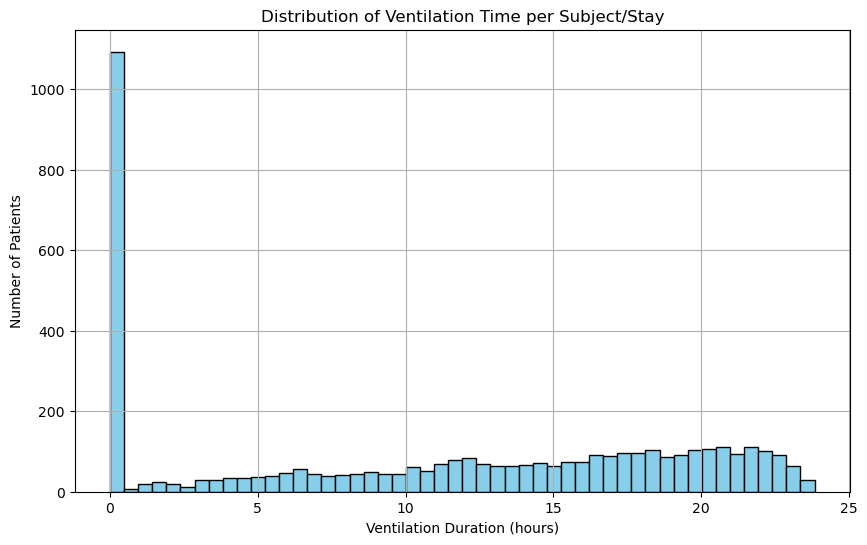

In [32]:
# Group by subject_id compute duration
duration_df = (
    bloodgas6
    .groupby(['subject_id'])['charttime']
    .agg(['min', 'max'])
    .reset_index()
)

# Calculate duration in hours
duration_df['duration_hours'] = (duration_df['max'] - duration_df['min']).dt.total_seconds() / 3600

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(duration_df['duration_hours'], bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Ventilation Duration (hours)')
plt.ylabel('Number of Patients')
plt.title('Distribution of Ventilation Time per Subject/Stay')
plt.grid(True)
plt.show()

In [33]:
# Group by subject_id and itemid, count number of samples
group_counts = (
    bloodgas6
    .groupby(['subject_id', 'itemid'])
    .size()
    .reset_index(name='sample_count')
)

# Compute average sample count per itemid
avg_samples = (
    group_counts
    .groupby('itemid')['sample_count']
    .mean()
    .reset_index(name='avg_samples_per_subject_stay')
)

# If 'label' exists and is associated uniquely with itemid, merge it in
if 'label' in bloodgas6.columns:
    itemid_label_map = bloodgas6[['itemid', 'label']].drop_duplicates()
    avg_samples = avg_samples.merge(itemid_label_map, on='itemid', how='left')

# Reorder columns if needed
avg_samples = avg_samples[['itemid', 'label', 'avg_samples_per_subject_stay']] if 'label' in avg_samples.columns else avg_samples

In [34]:
avg_samples

,itemid,label,avg_samples_per_subject_stay
0,50802,Base Excess,3.435440
1,50803,"Calculated Bicarbonate, Whole Blood",1.250000
2,50806,"Chloride, Whole Blood",1.680645
3,50809,Glucose,2.839802
4,50810,"Hematocrit, Calculated",1.800937
5,50811,Hemoglobin,1.798595
6,50813,Lactate,2.478033
7,50818,pCO2,3.443371
8,50820,pH,3.558356
9,50821,pO2,3.442765


In [35]:
bloodgas7 = bloodgas6.copy()

In [44]:
bloodgas7.shape

(72748, 6)

In [45]:
# On the basis of other feature set analysis, aim for a sampling frequency of at least once every 4 hours, which is 7 measurements in 24h

from sklearn.model_selection import train_test_split

target_frequency = 7

In [46]:
def calculate_synthetic_data_proportion(df, patient_id_col, feature_col, target_frequency=13):
    synthetic_data_proportion = {}
    for patient_id in df[patient_id_col].unique():
        patient_data = df[df[patient_id_col] == patient_id]
        total_entries = len(patient_data)
        synthetic_entries = 0
        for feature in df[feature_col].unique():
            feature_data = patient_data[patient_data[feature_col] == feature]
            observed_count = len(feature_data)
            if observed_count < target_frequency:
                synthetic_entries += (target_frequency - observed_count)
        synthetic_data_proportion[patient_id] = synthetic_entries / total_entries
    return synthetic_data_proportion

In [47]:
# Calculate the synthetic data proportion that will be required for each feature
synthetic_data_proportion = calculate_synthetic_data_proportion(bloodgas7, 'subject_id', 'itemid', target_frequency)
synthetic_data_proportion_df = pd.DataFrame(list(synthetic_data_proportion.items()), columns=['subject_id', 'synthetic_data_proportion'])
synthetic_data_proportion_df

,subject_id,synthetic_data_proportion
0,10002428,5.000000
1,10004235,1.400000
2,10005817,6.636364
3,10006053,7.400000
4,10013643,4.600000
...,...,...
4128,19990821,2.652174
4129,19991446,7.400000
4130,19997293,15.800000
4131,19997367,0.884615


In [48]:
def calculate_patient_synthetic_data_proportion(patient_data, target_frequency=13):
    patient_synthetic_data_proportion = {}
    for patient_id, group in patient_data.groupby('subject_id'):
        observed_count = group['label'].count()
        total_expected = len(group) * target_frequency
        synthetic_count = total_expected - observed_count
        synthetic_proportion = synthetic_count / total_expected
        patient_synthetic_data_proportion[patient_id] = synthetic_proportion
    return patient_synthetic_data_proportion  

In [49]:
def create_synthetic_data_proportion_df(patient_data):
    synthetic_data_proportion = calculate_patient_synthetic_data_proportion(patient_data)
    synthetic_df = pd.DataFrame(list(synthetic_data_proportion.items()), columns=['subject_id', 'synthetic_proportion'])
    return synthetic_df

In [50]:
def stratified_split(patient_data, test_size=0.2, random_state=42):
    synthetic_df = create_synthetic_data_proportion_df(patient_data)
    train_ids, test_ids = train_test_split(
        synthetic_df['subject_id'],
        test_size=test_size,
        random_state=random_state,
        stratify=synthetic_df['synthetic_proportion']
    )
    train_data = patient_data[patient_data['subject_id'].isin(train_ids)]
    test_data = patient_data[patient_data['subject_id'].isin(test_ids)]
    return train_data, test_data

In [51]:
# Split into train and test data
train_data, test_data = stratified_split(bloodgas7, test_size=0.2, random_state=42)

print(f"Total number of patients in train set: {len(train_data['subject_id'].unique())}")
print(f"Total number of patients in test set: {len(test_data['subject_id'].unique())}")

Total number of patients in train set: 3306
Total number of patients in test set: 827


In [52]:
def compare_synthetic_data_proportions(train_df, test_df, patient_id_col, feature_col, target_frequency=13):
    train_synthetic_data_proportion = calculate_synthetic_data_proportion(train_df, patient_id_col, feature_col, target_frequency)
    test_synthetic_data_proportion = calculate_synthetic_data_proportion(test_df, patient_id_col, feature_col, target_frequency)

    train_avg_synthetic_data_proportion = sum(train_synthetic_data_proportion.values()) / len(train_synthetic_data_proportion)
    test_avg_synthetic_data_proportion = sum(test_synthetic_data_proportion.values()) / len(test_synthetic_data_proportion)

    print(f"Train Average Synthetic Data Proportion: {train_avg_synthetic_data_proportion:.4f}")
    print(f"Test Average Synthetic Data Proportion: {test_avg_synthetic_data_proportion:.4f}")

def compare_class_distributions(train_df, test_df, target_col):
    train_class_distribution = train_df[target_col].value_counts(normalize=True)
    test_class_distribution = test_df[target_col].value_counts(normalize=True)

    print("Train Class Distribution:")
    print(train_class_distribution)
    print("\nTest Class Distribution:")
    print(test_class_distribution)

def compare_feature_distributions(train_df, test_df, feature_cols):
    train_feature_stats = train_df[feature_cols].describe().transpose()
    test_feature_stats = test_df[feature_cols].describe().transpose()

    comparison_df = train_feature_stats[['mean', 'std']].merge(
        test_feature_stats[['mean', 'std']],
        left_index=True,
        right_index=True,
        suffixes=('_train', '_test')
    )

    print("\nFeature Statistics Comparison:")
    print(comparison_df)

In [53]:
# Synthetic data requirement between test and train datasets

compare_synthetic_data_proportions(train_data, test_data, 'subject_id', 'label', target_frequency)

Train Average Synthetic Data Proportion: 8.8182
Test Average Synthetic Data Proportion: 8.6740


In [54]:
def compare_class_distributions(train_df, test_df, target_col):
    train_class_distribution = train_df[target_col].value_counts(normalize=True)
    test_class_distribution = test_df[target_col].value_counts(normalize=True)

    print("Train Class Distribution:")
    print(train_class_distribution)
    print("\nTest Class Distribution:")
    print(test_class_distribution)

In [55]:
# Outcome proportions between test and train datasets

compare_class_distributions(train_data, test_data, 'ext_success')

Train Class Distribution:
ext_success
1    0.73756
0    0.26244
Name: proportion, dtype: float64

Test Class Distribution:
ext_success
1    0.724534
0    0.275466
Name: proportion, dtype: float64


In [56]:
def compare_feature_stats(train_df, test_df, feature_labels):
    results = []

    for label in feature_labels:
        train_vals = train_df[train_df['label'] == label]['valuenum'].dropna()
        test_vals = test_df[test_df['label'] == label]['valuenum'].dropna()

        if len(train_vals) == 0 or len(test_vals) == 0:
            continue  # skip if no data in one of the splits

        results.append({
            'feature': label,
            'mean_train': train_vals.mean(),
            'std_train': train_vals.std(),
            'mean_test': test_vals.mean(),
            'std_test': test_vals.std()
        })

    comparison_df = pd.DataFrame(results)
    print("\nFeature Statistics Comparison:")
    print(comparison_df)

    return comparison_df

In [63]:
# Normalise each value using MinMaxScalar

from sklearn.preprocessing import MinMaxScaler

# Create an empty list to hold the normalized data
normalized_frames = []

# Loop through each itemid and normalize valuenum within its group
for itemid, group in train_data.groupby('itemid'):
    scaler = MinMaxScaler()
    group = group.copy()  # avoid SettingWithCopyWarning
    group['valuenum_normalized'] = scaler.fit_transform(group[['valuenum']])
    normalized_frames.append(group)

# Concatenate all normalized groups back together
train_data = pd.concat(normalized_frames, ignore_index=True)

In [64]:
train_data.head()

,subject_id,charttime,itemid,valuenum,label,ext_success,valuenum_normalized
0,10002428,2156-04-22 03:26:00,50802,4.0,Base Excess,1,0.58
1,10002428,2156-04-22 10:31:00,50802,2.0,Base Excess,1,0.54
2,10002428,2156-04-22 16:52:00,50802,4.0,Base Excess,1,0.58
3,10005817,2135-01-19 11:32:00,50802,10.0,Base Excess,0,0.70
4,10005817,2135-01-19 12:50:00,50802,8.0,Base Excess,0,0.66


In [65]:
train_data = train_data[['subject_id', 'charttime', 'itemid', 'label', 'valuenum_normalized', 'ext_success']]

train_data.head()

,subject_id,charttime,itemid,label,valuenum_normalized,ext_success
0,10002428,2156-04-22 03:26:00,50802,Base Excess,0.58,1
1,10002428,2156-04-22 10:31:00,50802,Base Excess,0.54,1
2,10002428,2156-04-22 16:52:00,50802,Base Excess,0.58,1
3,10005817,2135-01-19 11:32:00,50802,Base Excess,0.70,0
4,10005817,2135-01-19 12:50:00,50802,Base Excess,0.66,0


In [66]:
train_data = train_data.sort_values(by=['subject_id', 'charttime']).reset_index(drop=True)

train_data.head()

,subject_id,charttime,itemid,label,valuenum_normalized,ext_success
0,10002428,2156-04-22 00:45:00,50813,Lactate,0.042636,1
1,10002428,2156-04-22 03:26:00,50802,Base Excess,0.580000,1
2,10002428,2156-04-22 03:26:00,50818,pCO2,0.230216,1
3,10002428,2156-04-22 03:26:00,50820,pH,0.604839,1
4,10002428,2156-04-22 03:26:00,50821,pO2,0.282000,1


In [67]:
# Normalise each value using MinMaxScalar

from sklearn.preprocessing import MinMaxScaler

# Create an empty list to hold the normalized data
normalized_frames = []

# Loop through each itemid and normalize valuenum within its group
for itemid, group in test_data.groupby('itemid'):
    scaler = MinMaxScaler()
    group = group.copy()  # avoid SettingWithCopyWarning
    group['valuenum_normalized'] = scaler.fit_transform(group[['valuenum']])
    normalized_frames.append(group)

# Concatenate all normalized groups back together
test_data = pd.concat(normalized_frames, ignore_index=True)

In [68]:
test_data = test_data[['subject_id', 'charttime', 'itemid', 'label', 'valuenum_normalized', 'ext_success']]
test_data = test_data.sort_values(by=['subject_id', 'charttime']).reset_index(drop=True)

In [69]:
test_data.head()

,subject_id,charttime,itemid,label,valuenum_normalized,ext_success
0,10004235,2196-02-26 16:30:00,50802,Base Excess,0.488889,1
1,10004235,2196-02-26 16:30:00,50813,Lactate,0.072874,1
2,10004235,2196-02-26 16:30:00,50818,pCO2,0.258065,1
3,10004235,2196-02-26 16:30:00,50820,pH,0.659091,1
4,10004235,2196-02-26 16:30:00,50821,pO2,0.155206,1


In [70]:
import os

train_data.to_csv("/Users/mmurali1/Documents/Imperial/MIMICIV_analysis/bloodgas_cleaned_train.csv", index=False)
test_data.to_csv("/Users/mmurali1/Documents/Imperial/MIMICIV_analysis/bloodgas_cleaned_test.csv", index=False)